# Tutorial on DINCAE

This script/notebook reconstructs missing data in satellite data using a neural
network architecture called convolutional auto-encoder described in the
following articles:

* Barth, A., Alvera-Azcárate, A., Licer, M., and Beckers, J.-M.: DINCAE 1.0: a convolutional neural network with error estimates to reconstruct sea surface temperature satellite observations, Geosci. Model Dev., 13, 1609–1622, https://doi.org/10.5194/gmd-13-1609-2020, 2020.
* Barth, A., Alvera-Azcárate, A., Troupin, C., & Beckers, J.-M. (2022). DINCAE 2.0: multivariate convolutional neural network with error estimates to reconstruct sea surface temperature satellite and altimetry observations. Geoscientific Model Development, 15(5), 2183–2196. https://doi.org/10.5194/gmd-15-2183-2022

The example here uses MODIS sea surface temperature from the Physical
Oceanography Distributed Active Archive Center (PO.DAAC) JPL, NASA.
More information is available at https://dx.doi.org/10.5067/MODST-1D4D9

This notebook/script is indented to be run on a GPU with CUDA support (NVIDIA GPU)
with a least 8 GB of RAM.

Dependencies are installed with:

```julia
using Pkg
Pkg.add(["CUDA","Knet","NCDatasets","PyPlot"])
Pkg.add(url="https://github.com/gher-uliege/DINCAE_utils.jl", rev="main")
```

See also https://github.com/gher-ulg/DINCAE.jl#installation

Load the necessary modules

In [1]:
using CUDA
using DINCAE
using DINCAE_utils
using Dates
using Knet
using NCDatasets
using PyPlot
using Printf
using Downloads: download

## Data download

First we define the domain and time interval.

The example is tested here for a short time frame but for realistic
applications one should use a much longer time-range (like 10, 20 years or more)

In [2]:
# longitude range (east, west)
lon_range = [-33, -24]
# latitude range (south, north)
lat_range = [33.0, 40.0]

2-element Vector{Float64}:
 33.0
 40.0

In [3]:
# time range (start, end)
time_range = [DateTime(2017,1,1), DateTime(2019,12,31)]

2-element Vector{DateTime}:
 2017-01-01T00:00:00
 2019-12-31T00:00:00

In [4]:
# local directory
localdir = expanduser("~/Data/SST-Azores")
# create directory
mkpath(localdir)
# filename of the subset
fname_subset = joinpath(localdir,"modis_subset.nc")
# filename of the clean data
fname = joinpath(localdir,"modis_cleanup.nc")
# filename of the data with added clouds for cross-validation
fname_cv = joinpath(localdir,"modis_cleanup_add_clouds.nc")
varname = "sst"

"sst"

Results of DINCAE will be placed in a sub-directory under `localdir`

In [5]:
outdir = joinpath(localdir,"Results")
mkpath(outdir)

"/home/jovyan/Data/SST-Azores/Results"

Download the MODIS subset:

In [6]:
if !isfile(fname_subset)
    download("https://dox.ulg.ac.be/index.php/s/a1Lk2sG4onZR5Gg/download",fname_subset)
end

"/home/jovyan/Data/SST-Azores/modis_subset.nc"

The MODIS subset was generated by the following code:

```julia
for dt in time_range[1]:Day(1):time_range[end]
    yyyy = Dates.format(dt,"yyyy")
    mm = Dates.format(dt,"mm")
    dd = Dates.format(dt,"dd")
    doy = @sprintf("%03d",Dates.dayofyear(dt))
    url = "https://podaac-opendap.jpl.nasa.gov:443/opendap/allData/modis/L3/terra/11um/v2019.0/4km/daily/$yyyy/$doy/TERRA_MODIS.$(yyyy)$(mm)$(dd).L3m.DAY.NSST.sst.4km.nc"
    filename = joinpath(localdir,"TERRA_MODIS.$(yyyy)$(mm)$(dd).L3m.DAY.NSST.sst.4km.nc")
    if isfile(filename)
        continue
    end
    try
        ds = NCDataset(url)
        ds_subset = NCDatasets.@select(ds,$(lon_range[1]) <= lon <= $(lon_range[2]) && $(lat_range[1]) <= lat <= $(lat_range[2]))
        write(filename,ds_subset)
        push!(filenames,filename)
        close(ds)
        println("$dt downloaded")
    catch e
        showerror(stdout, e)
        @warn("no data for $dt")
    end
end

filenames = String[]
time = DateTime[]

for dt in time_range[1]:Day(1):time_range[end]
    yyyy = Dates.format(dt,"yyyy")
    mm = Dates.format(dt,"mm")
    dd = Dates.format(dt,"dd")
    filename = joinpath(localdir,"TERRA_MODIS.$(yyyy)$(mm)$(dd).L3m.DAY.NSST.sst.4km.nc")
    if isfile(filename)
        push!(filenames,filename)
        push!(time,dt)
    end
end

ds = NCDataset(filenames,aggdim="time",isnewdim=true,
               constvars = ["lon","lat"]);
ds2 = NCDataset(fname_subset,"c")
write(ds2,ds)
defVar(ds2,"time",time,("time",))
close(ds2)
close(ds)
```

In [7]:
ds = NCDataset(fname_subset,"r")
sst = ds["sst"][:,:,:];
qual = ds["qual_sst"][:,:,:];

In [8]:
@show extrema(skipmissing(qual))
@show extrema(skipmissing(sst))

extrema(skipmissing(qual)) = (0, 2)
extrema(skipmissing(sst)) = (9.995f0, 28.21f0)


(9.995f0, 28.21f0)

We ignore all data points with missing quality flags,
quality indicator exceeding 3 and temperature
larger than 40°C (not necessary for this particular dataset)

In [9]:
sst_t = copy(sst)
sst_t[(qual .> 3) .& .!ismissing.(qual)] .= missing
sst_t[(sst_t .> 40) .& .!ismissing.(sst_t)] .= missing

0-element view(reshape(::Array{Union{Missing, Float32}, 3}, 39662784), Int64[]) with eltype Union{Missing, Float32}

In [10]:
@info "number of missing observations: $(count(ismissing,sst_t))"
@info "number of valid observations: $(count(.!ismissing,sst_t))"

[ Info: number of missing observations: 25591782
[ Info: number of valid observations: 14071002


Clean-up the data to them write to disk

In [11]:
isfile("modis_cleanup.nc") && rm("modis_cleanup.nc")
varname = "sst"
fname = joinpath(localdir,"modis_cleanup.nc")
ds2 = NCDataset(fname,"c")
write(ds2,ds,exclude = ["sst","qual"])
defVar(ds2,varname,sst_t,("lon","lat","time"))
close(ds2)

closed NetCDF NCDataset

Add a land-sea mask to the file grid points with less than 5% of
valid data are considerd as land

In [12]:
DINCAE_utils.add_mask(fname,varname; minseafrac = 0.05)

NetCDF variable (file closed)

Choose cross-validation points by adding clouds to the cleanest
images (copied from the cloudiest images). This function will generate
a file `fname_cv`.

In [13]:
DINCAE_utils.addcvpoint(fname,varname; mincvfrac = 0.10);

(n_dest, time[n_dest], nmissing_after - nmissing_before, ncv, mincvfrac * nvalid) = (607, DateTime("2018-08-30T00:00:00"), 32002, 32002, 1.4070414000000001e6)
(n_dest, time[n_dest], nmissing_after - nmissing_before, ncv, mincvfrac * nvalid) = (930, DateTime("2019-07-20T00:00:00"), 28733, 60735, 1.4070414000000001e6)
(n_dest, time[n_dest], nmissing_after - nmissing_before, ncv, mincvfrac * nvalid) = (921, DateTime("2019-07-11T00:00:00"), 20115, 80850, 1.4070414000000001e6)
(n_dest, time[n_dest], nmissing_after - nmissing_before, ncv, mincvfrac * nvalid) = (593, DateTime("2018-08-16T00:00:00"), 12378, 93228, 1.4070414000000001e6)
(n_dest, time[n_dest], nmissing_after - nmissing_before, ncv, mincvfrac * nvalid) = (46, DateTime("2017-02-15T00:00:00"), 26861, 120089, 1.4070414000000001e6)
(n_dest, time[n_dest], nmissing_after - nmissing_before, ncv, mincvfrac * nvalid) = (588, DateTime("2018-08-11T00:00:00"), 32445, 152534, 1.4070414000000001e6)
(n_dest, time[n_dest], nmissing_after - nmiss

┌ Info: number cross-validation points 
└   ncv = 1419513
┌ Info: percentage of cross-validation points 
└   (100ncv) / nvalid = 10.088637050764818


# Reconstruct missing data


F is the floating point number type for neural network, here we use
single precision

In [14]:
const F = Float32

Float32

Test if CUDA is functional to use the GPU, otherwise the CPU is used.

In [15]:
if CUDA.functional()
    Atype = KnetArray{F}
else
    @warn "No supported GPU found. We will use the CPU which is very slow. Please check https://developer.nvidia.com/cuda-gpus"
    Atype = Array{F}
end

┌ Warning: No supported GPU found. We will use the CPU which is very slow. Please check https://developer.nvidia.com/cuda-gpus
└ @ Main In[15]:4


Array{Float32}

In [16]:
Knet.atype() = Atype

Setting the paramenters of neural network
see document of DINCAE.reconstruct for more information

In [17]:
epochs = 1000
batch_size = 32
enc_nfilter_internal = round.(Int,32 * 2 .^ (0:4))
clip_grad = 5.0
regularization_L2_beta = 0
ntime_win = 3
upsampling_method = :nearest
loss_weights_refine = (0.3,0.7)
save_epochs = 200:10:epochs

200:10:1000

In [18]:
data = [
   (filename = fname_cv,
    varname = varname,
    obs_err_std = 1,
    jitter_std = 0.05,
    isoutput = true,
   )
]
data_test = data;
fnames_rec = [joinpath(outdir,"data-avg.nc")]
data_all = [data,data_test]

2-element Vector{Vector{NamedTuple{(:filename, :varname, :obs_err_std, :jitter_std, :isoutput), Tuple{String, String, Int64, Float64, Bool}}}}:
 [(filename = "/home/jovyan/Data/SST-Azores/modis_cleanup_add_clouds.nc", varname = "sst", obs_err_std = 1, jitter_std = 0.05, isoutput = 1)]
 [(filename = "/home/jovyan/Data/SST-Azores/modis_cleanup_add_clouds.nc", varname = "sst", obs_err_std = 1, jitter_std = 0.05, isoutput = 1)]

Use these parameters for a quick test:

epochs = 10
save_epochs = epochs:epochs

Start the training and reconstruction of the neural network
This takes a long time. You can cancel this step and get the
sample result.

```julia
loss = DINCAE.reconstruct(
    Atype,data_all,fnames_rec;
    epochs = epochs,
    batch_size = batch_size,
    enc_nfilter_internal = enc_nfilter_internal,
    clip_grad = clip_grad,
    save_epochs = save_epochs,
    upsampling_method = upsampling_method,
    loss_weights_refine = loss_weights_refine,
    ntime_win = ntime_win,
)
```

Download the result and load the loss

In [19]:
if !isfile(fnames_rec[1])
    download("https://dox.ulg.ac.be/index.php/s/91OnKoK0CUE3a8V/download",fnames_rec[1])
end
loss =
    NCDataset(fnames_rec[1]) do ds
        ds["losses"][:]
    end

1000-element Vector{Float64}:
  2.6509844498974933
  0.6473746311664579
  0.4215355967623848
  0.23523193581561955
  0.21966957172462045
  0.1155703649523535
  0.04859859980725948
  0.016391583709378856
 -0.012983327716522454
 -0.06504221366585364
 -0.06483554802751834
 -0.14255169023626615
 -0.10839240813561317
  ⋮
 -1.4069635360581532
 -1.4293950176239014
 -1.4458727683339798
 -1.40832601921899
 -1.4276547837257383
 -1.4886608569962638
 -1.4945108910969325
 -1.505952879531043
 -1.4996476789883204
 -1.486514375209808
 -1.4359892674854826
 -1.4075962257385257

Plot the loss function

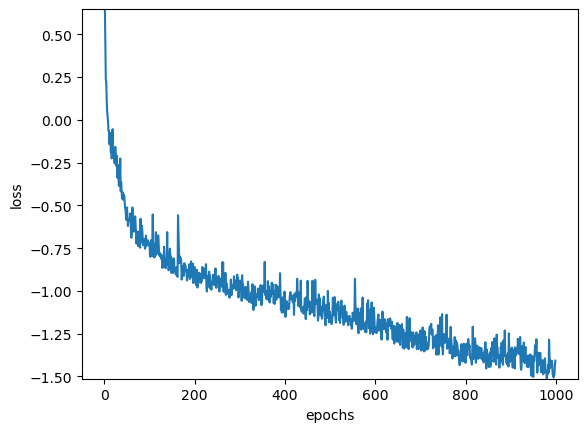

In [20]:
plot(loss)
ylim(extrema(loss[2:end]))
xlabel("epochs")
ylabel("loss");

# Post process results

Compute the RMS with the independent validation data

In [21]:
case = (
    fname_orig = fname,
    fname_cv = fname_cv,
    varname = varname,
)
fnameavg = joinpath(outdir,"data-avg.nc")
cvrms = DINCAE_utils.cvrms(case,fnameavg)
@info "Cross-validation RMS error is: $cvrms"

ntest = 1093
size(batch_m_true) = (216, 168, 1093)


[ Info: Cross-validation RMS error is: 0.37668785


Next we plot all time instances. The figures with be placed in the
directory `figdir`

plot 2017-02-15T00:00:00


[ Info: Downloading file 'lsmask_5min_f.bin' from 'https://raw.githubusercontent.com/matplotlib/basemap/v1.2.2rel/lib/mpl_toolkits/basemap/data/lsmask_5min_f.bin' with cURL.


plot 2017-02-17T00:00:00
plot 2017-05-11T00:00:00
plot 2017-05-17T00:00:00
plot 2017-06-24T00:00:00
plot 2017-07-24T00:00:00
plot 2017-07-25T00:00:00
plot 2017-07-26T00:00:00
plot 2017-07-30T00:00:00
plot 2017-08-02T00:00:00
plot 2017-08-13T00:00:00
plot 2017-08-15T00:00:00
plot 2017-08-16T00:00:00
plot 2017-08-18T00:00:00
plot 2017-09-02T00:00:00
plot 2017-09-25T00:00:00
plot 2017-09-30T00:00:00
plot 2017-10-01T00:00:00
plot 2017-10-02T00:00:00
plot 2017-10-12T00:00:00
plot 2018-06-01T00:00:00
plot 2018-06-13T00:00:00
plot 2018-08-11T00:00:00
plot 2018-08-12T00:00:00
plot 2018-08-15T00:00:00
plot 2018-08-16T00:00:00
plot 2018-08-18T00:00:00
plot 2018-08-20T00:00:00
plot 2018-08-29T00:00:00
plot 2018-08-30T00:00:00
plot 2018-08-31T00:00:00
plot 2018-09-01T00:00:00
plot 2018-09-03T00:00:00
plot 2018-09-09T00:00:00
plot 2018-09-10T00:00:00
plot 2018-09-11T00:00:00
plot 2018-09-12T00:00:00
plot 2018-09-19T00:00:00
plot 2018-09-21T00:00:00
plot 2018-09-22T00:00:00
plot 2018-09-23T00:00:00


[ Info: Figures are in /home/jovyan/Data/SST-Azores/Results/Fig


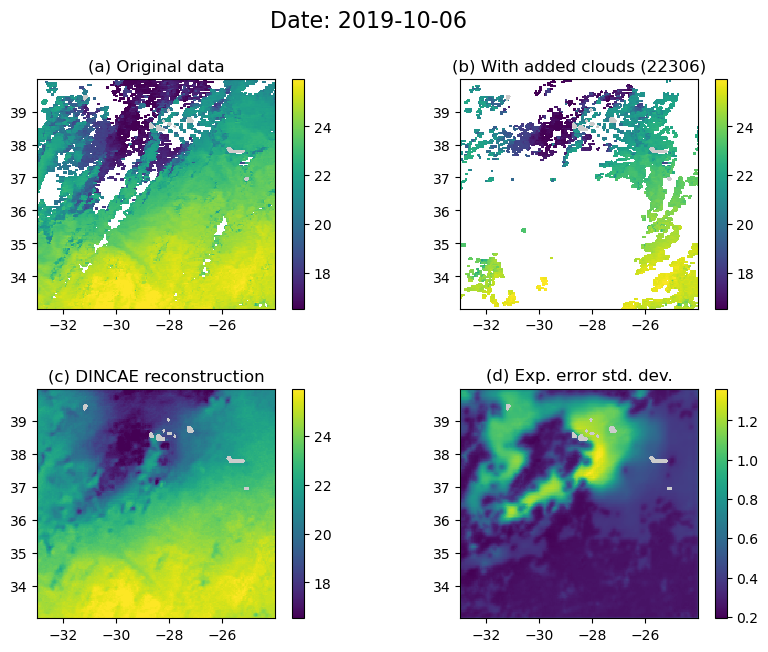

In [22]:
figdir = joinpath(outdir,"Fig")
DINCAE_utils.plotres(case,fnameavg, clim = nothing, figdir = figdir,
                     clim_quantile = (0.01,0.99),
                     which_plot = :cv)
@info "Figures are in $(figdir)"